# Unsupervised Anomaly Detection with​ Generative Adversarial Networks (GAN)
# Author: LE VAN CONG ​
1. モデル: GAN

2. データセット: washer

3. フレームワーク: Pytorch

#パッケージのimport

In [ ]:
!pip install dl-cliche
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

# denormalize
def to_raw_image(img, denorm_tensor=True):
    if type(img) == torch.Tensor:
        img = img.detach().cpu().numpy().transpose(1, 2, 0)
        if denorm_tensor:
            img = (img * 0.5) + 0.5
        img = (img * 255).astype(np.uint8)
    return img

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Generatorの実装

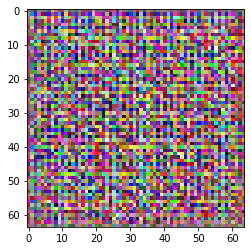

(64, 64, 3)


In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 8*8*256),
            nn.BatchNorm1d(8*8*256),
            nn.ReLU(inplace=True))

        layers = []
        for k_in, k_out in [(256, 128), (128, 64)]:
            layers.append(nn.ConvTranspose2d(in_channels=k_in, out_channels=k_out,
                               kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(k_out))
            layers.append(nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(*layers)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, # dl 3chへ変更
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 転置畳み込み層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 256, 8, 8)
        out = self.layer3(out)
        out = self.last(out)
        return out

# 動作確認
import matplotlib.pyplot as plt
G = Generator(z_dim=20)
G.train()

# 入力する乱数
# バッチノーマライゼーションがあるのでミニバッチ数は2以上
input_z = torch.randn(2, 20)

# 偽画像を出力
fake_images = G(input_z)  # torch.Size([2, 1, 64, 64])
img_transformed = to_raw_image(fake_images[0].detach())
plt.imshow(img_transformed, 'gray')
plt.show()
print(img_transformed.shape)

# Discriminatorの実装

In [ ]:
class Discriminator(nn.Module):
  
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 画像側の入力処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, # dl カラー対応
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 乱数側の入力処理
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Linear(16896, 1024), # 16896 = 16384 + 512
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_outとz_outを結合し、全結合層で判定
        x_out = x_out.view(z.shape[0], -1)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last2(out)

        return out, feature

#動作確認
D = Discriminator(z_dim=20)

# 偽画像を生成
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 偽画像をDに入力
d_out, _ = D(fake_images, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[0.4053],
        [0.4419]], grad_fn=<SigmoidBackward>)


# PreTrainの実装

In [ ]:
import numpy as np
from dlcliche.utils import Path, ensure_delete, ensure_folder
from PIL import Image

class TrainPrep(object):
    def __init__(self, project_name, train_files, load_size, crop_size, suffix,
                 pre_crop_rect=None, extra='', skip_file_creation=False):
        self.project, self.load_size, self.crop_size = project_name, load_size, crop_size
        self.suffix, self.pre_crop_rect, self.extra = suffix, pre_crop_rect, extra
        self.root = Path(f'./tmp/{self.project}')
        self.train = self.root/'train'
        self.test = self.root/'test'
        self.prepare_train(train_files, skip_file_creation)

    def copy_files_pre_crop(self, dest, files, skip_file_creation):
        new_filenames = []
        for f in files:
            file_name = str((dest/f'{f.parent.name}-{f.name}').with_suffix(self.suffix))
            assert file_name not in new_filenames
            if not skip_file_creation:
                img = Image.open(f).convert('RGB')
                if self.pre_crop_rect is not None:
                    img = img.crop(self.pre_crop_rect)
                img = img.resize((self.load_size, self.load_size))
                img.save(file_name)
            new_filenames.append(file_name)
        return new_filenames

    def prepare_train(self, train_files, skip_file_creation):
        if not skip_file_creation:
            ensure_delete(self.train)
            ensure_folder(self.train)
        self.train_files = self.copy_files_pre_crop(self.train, train_files, skip_file_creation)

    def prepare_test(self, test_files, skip_file_creation=False):
        if not skip_file_creation:
            ensure_delete(self.test)
            ensure_folder(self.test)
        self.test_files = self.copy_files_pre_crop(self.test, test_files, skip_file_creation=skip_file_creation)

def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    # 画像ファイルパスを格納
    train_img_list = sorted(DATA_ROOT.glob(f'washer_ok/*{SUFFIX}'))

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

def random_crop(opt, pil_img):
    w, h = pil_img.size
    if opt.random:
        x = random.randint(0, np.maximum(0, w - opt.crop_size))
        y = random.randint(0, np.maximum(0, h - opt.crop_size))
    else:
        x = (w - opt.crop_size) // 2
        y = (h - opt.crop_size) // 2
    return pil_img.crop((x, y, x+opt.crop_size, y+opt.crop_size))

# Dataloaderの実装

In [ ]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, load_size, crop_size, transform, random, debug=None):
        self.file_list = file_list
        self.load_size, self.crop_size = load_size, crop_size
        self.transform, self.random, self.debug = transform, random, debug

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''
        if self.debug is not None: print(f'{self.debug}[{index}]')

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色] # dl カラー対応
        img = img.resize((self.load_size, self.load_size))
        img = random_crop(self, img)

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed

# DataLoaderの作成と動作確認
from torch.utils.data import DataLoader
DATA_ROOT = Path('/content/drive/My Drive/Project/washer/')
SUFFIX = '.jpg'
SIZE = 64
batch_size = 64

# ファイルリストを作成
train_img_list=make_datapath_list()

# リサイズして準備
prep = TrainPrep('gan-dataset', train_img_list, load_size=SIZE+4, crop_size=SIZE, suffix=SUFFIX,
                #skip_file_creation=True
                )

# Datasetを作成
train_dataset = GAN_Img_Dataset(file_list=prep.train_files, load_size=SIZE + 4, crop_size=SIZE, transform=ImageTransform(), random=True)

# DataLoaderを作成
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 3, 64, 64])  # dl カラー対応

torch.Size([30, 3, 64, 64])


# Training の実装

In [ ]:
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# モデルを学習させる関数を作成

def train_model(G, D, dataloader, num_epochs):

    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('Epoch {}/{}'.format(epoch, num_epochs))

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真の画像を判定　
            # z_out_real = E(imges)
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            d_out_real, _ = D(imges, input_z)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)


# 初期化の実施
G.apply(weights_init)
# E.apply(weights_init)
D.apply(weights_init)

使用デバイス： cuda:0


Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (x_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (z_layer1): Linear(in_features=20, out_features=512, bias=True)
  (last1): Sequential(
    (0): Linear(in_features=16896, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
%%time
# 学習・検証を実行する 42-90分ほどかかる
num_epochs = 5000
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

Streaming output truncated to the last 5000 lines.
timer:  0.1018 sec.
Epoch 3335/5000
epoch 3335 || Epoch_D_Loss:0.0235 ||Epoch_G_Loss:0.0104
timer:  0.1044 sec.
Epoch 3336/5000
epoch 3336 || Epoch_D_Loss:0.0236 ||Epoch_G_Loss:0.0101
timer:  0.1060 sec.
Epoch 3337/5000
epoch 3337 || Epoch_D_Loss:0.0238 ||Epoch_G_Loss:0.0105
timer:  0.1056 sec.
Epoch 3338/5000
epoch 3338 || Epoch_D_Loss:0.0235 ||Epoch_G_Loss:0.0105
timer:  0.1036 sec.
Epoch 3339/5000
epoch 3339 || Epoch_D_Loss:0.0236 ||Epoch_G_Loss:0.0102
timer:  0.1049 sec.
Epoch 3340/5000
epoch 3340 || Epoch_D_Loss:0.0233 ||Epoch_G_Loss:0.0098
timer:  0.1038 sec.
Epoch 3341/5000
epoch 3341 || Epoch_D_Loss:0.0236 ||Epoch_G_Loss:0.0104
timer:  0.1057 sec.
Epoch 3342/5000
epoch 3342 || Epoch_D_Loss:0.0234 ||Epoch_G_Loss:0.0102
timer:  0.1027 sec.
Epoch 3343/5000
epoch 3343 || Epoch_D_Loss:0.0237 ||Epoch_G_Loss:0.0100
timer:  0.1029 sec.
Epoch 3344/5000
epoch 3344 || Epoch_D_Loss:0.0237 ||Epoch_G_Loss:0.0097
timer:  0.1017 sec.
Epoch 334

# Testing の実装

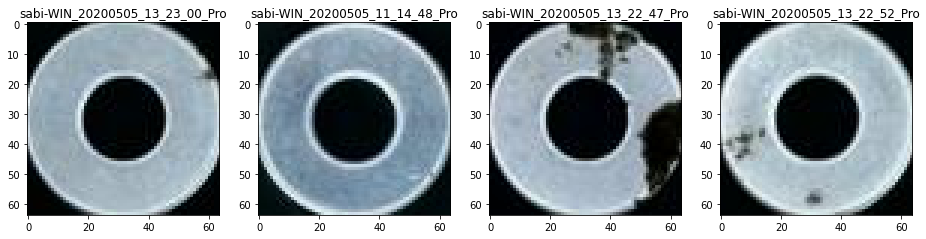

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# テスト用のDataLoaderの作成
DATA_TEST = Path('/content/drive/My Drive/Project/washer/washer_ng/')
def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    # 画像ファイルパスを格納
    train_img_list = sorted(DATA_TEST.glob(f'sabi/*{SUFFIX}'))

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

prep.prepare_test(test_img_list,
                  # skip_file_creation=True
                 )

# Datasetを作成
test_dataset = GAN_Img_Dataset(file_list=prep.test_files, load_size=SIZE + 4, crop_size=SIZE,
                               transform=ImageTransform(), random=False, #debug='test_ds'
                              )

# DataLoaderを作成
batch_size = 64
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import os
file_test = '/content/drive/My Drive/Project/washer/washer_ng/sabi'
length = len(os.listdir(file_test))
test_list = range(length)
batch_iterator = iter(test_dataloader)  # イテレータに変換
imge_test = next(batch_iterator)  # 1番目の要素を取り出す

for i in range(20): # number of rows of plot
    fig = plt.figure(figsize=(20, 20))
    for j in range(5):
      idex = i*5+j
      if (idex < length):
        plt.subplot(3, 5, j+1)
        org_img = to_raw_image(imge_test[idex-1].cpu().detach())
        plt.imshow(org_img)
        plt.title(f'{Path(prep.test_files[idex-1]).stem}')
    plt.show()

# Anomaly score の実装

In [ ]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    print(x.shape, fake_img.shape, z_out_real.shape)

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x.mean(1)-fake_img.mean(1))
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す

    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

# Test Modelの実装
1. 損失を計算する
2. 可視化元画像、再構成画像、差分画像 

torch.Size([4, 3, 64, 64]) torch.Size([4, 3, 64, 64]) torch.Size([4, 20])


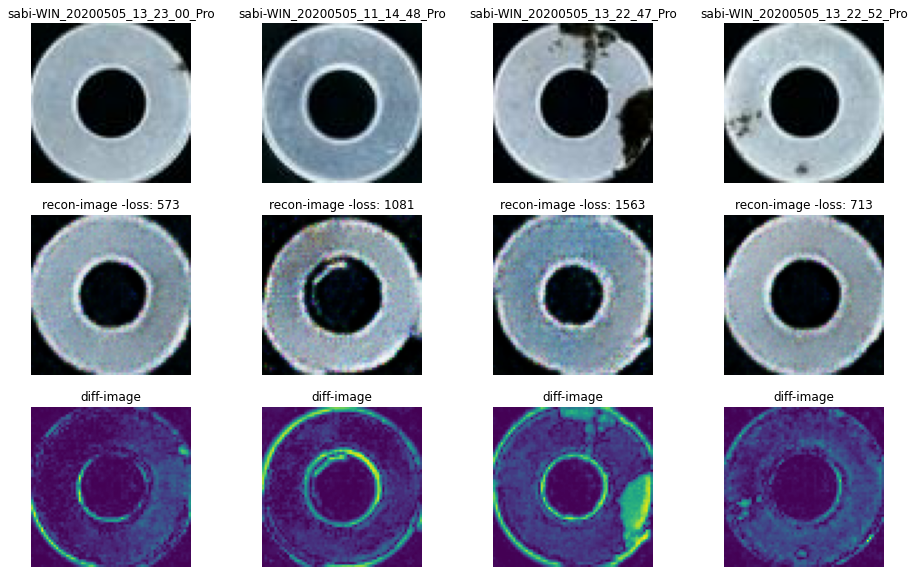

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [ ]:
# 教師データの画像をエンコードしてzにしてから、Gで生成
import numpy as np
# 異常検知したい画像を生成するための、初期乱数
mini_batch_size = imge_test.size()[0]
z_out_real = torch.randn(mini_batch_size, 20).to(device)
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    imge_test[test_list].to(device), imges_reconstract[test_list], z_out_real[test_list],
    D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
# print("total loss：", np.round(loss_each, 0))

# 画像を可視化
for i in range(20):
  fig = plt.figure(figsize=(20, 10))
  for j in range(5):
    idex = i*5+j
    if (idex < length):
      plt.subplot(3, 5, j+1)
      org_img = to_raw_image(imge_test[idex-1].cpu().detach())
      plt.imshow(org_img)
      # plt.title('origin-image-'+str(i*5+j+1))
      plt.title(f'{Path(prep.test_files[idex-1]).stem}')
      plt.axis('off')

      # 中段に生成データを表示する
      plt.subplot(3, 5, 5+j+1)
      reconst_img = to_raw_image(imges_reconstract[idex-1].cpu().detach())
      plt.imshow(reconst_img)
      # plt.title('recon-image')
      plt.title(f'recon-image -loss: {loss_each[idex-1]:.0f}')
      plt.axis('off')

      # 下段に差分を表示する
      plt.subplot(3, 5, 5+5+j+1)
      diff_img = np.abs(org_img.mean(axis=-1) - reconst_img.mean(axis=-1)) / 255.
      plt.imshow(diff_img)
      # plt.title('diff-image #'+str(i*5+j+1))
      plt.title(f'diff-image')
      plt.axis('off')
plt.show()